In [32]:
from lib import itselfmiti1
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, transpile,ClassicalRegister
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import Operator
from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit.utils.mitigation.fitters import CompleteMeasFitter,TensoredFilter,TensoredMeasFitter
from qiskit.ignis.mitigation.measurement import complete_meas_cal, tensored_meas_cal
import copy
from qiskit.ignis.verification.tomography import state_tomography_circuits
from IPython.display import clear_output
from qiskit.circuit.random import random_circuit
from qiskit.circuit import Parameter
from collections import Counter
from qiskit.visualization import plot_histogram
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.quantum_info as qi
#from qiskit.backends.jobstatus import JOB_FINAL_STATES

from lib import pauli_twirling




In [33]:

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibm_oslo'))
backend_real_jakarta = provider.get_backend('ibm_oslo')
backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND = backend_real_jakarta

ibmqfactory.load_account:WARNING:2022-10-26 16:07:09,916: Credentials are already in use. The existing account in the session will be replaced.


In [34]:
dt=np.pi/10
shots=20000
g=2
N_points=5
qubits=[1,3]
qubits_measure=qubits

In [35]:
t=dt
Trot_gate_qr=QuantumRegister(2)
Trot_gate=QuantumCircuit(Trot_gate_qr)

Trot_gate.cx(Trot_gate_qr[1],Trot_gate_qr[0])
Trot_gate.ry(-0.5*g*t,Trot_gate_qr[0])
Trot_gate.rz(-0.375*t,Trot_gate_qr[0])
Trot_gate.cx(Trot_gate_qr[1],Trot_gate_qr[0])
Trot_gate.ry(-1.5*g*t,Trot_gate_qr[0])
Trot_gate.rz(-2.25*t,Trot_gate_qr[0])
Trot_gate.rz(-1.125*t,Trot_gate_qr[1])
Trot_gate.ry(-3*g*t,Trot_gate_qr[1])
Trot_gate.cx(Trot_gate_qr[0],Trot_gate_qr[1])
Trot_gate.ry(-g*t,Trot_gate_qr[1])
Trot_gate.cx(Trot_gate_qr[0],Trot_gate_qr[1])
Trot_gate.ry(-1.5*g*t,Trot_gate_qr[0])
Trot_gate.rz(-1.125*t,Trot_gate_qr[1])
Trot_gate.cx(Trot_gate_qr[1],Trot_gate_qr[0])
Trot_gate.rz(-0.375*t,Trot_gate_qr[0])
Trot_gate.ry(-0.5*g*t,Trot_gate_qr[0])
Trot_gate.cx(Trot_gate_qr[1],Trot_gate_qr[0])

Trot_gate.draw()


┌───┐┌───────────┐┌──────────────┐┌───┐ ┌────────────┐ »
q3768_0: ┤ X ├┤ Ry(-π/10) ├┤ Rz(-0.11781) ├┤ X ├─┤ Ry(-3π/10) ├─»
         └─┬─┘└───────────┘└──────────────┘└─┬─┘┌┴────────────┴┐»
q3768_1: ──■─────────────────────────────────■──┤ Rz(-0.35343) ├»
                                                └──────────────┘»
«         ┌──────────────┐                       ┌────────────┐ ┌───┐»
«q3768_0: ┤ Rz(-0.70686) ├──■────────────────■───┤ Ry(-3π/10) ├─┤ X ├»
«         └┬───────────┬─┘┌─┴─┐┌──────────┐┌─┴─┐┌┴────────────┴┐└─┬─┘»
«q3768_1: ─┤ Ry(-3π/5) ├──┤ X ├┤ Ry(-π/5) ├┤ X ├┤ Rz(-0.35343) ├──■──»
«          └───────────┘  └───┘└──────────┘└───┘└──────────────┘     »
«         ┌──────────────┐┌───────────┐┌───┐
«q3768_0: ┤ Rz(-0.11781) ├┤ Ry(-π/10) ├┤ X ├
«         └──────────────┘└───────────┘└─┬─┘
«q3768_1: ───────────────────────────────■──
«

In [36]:
def final_circ(trotter_steps,qc=Trot_gate):
    qr=QuantumRegister(len(qubits),name="q")
    qc_aux=QuantumCircuit(qr)
    for i in range (0,trotter_steps):
        qc_aux.append(qc,qr)
    return qc_aux


In [37]:
backend=BACKEND
config=backend.configuration()
N_qubits_backend=config.n_qubits
qr = QuantumRegister(N_qubits_backend)
mit_pattern = [qubits_measure]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
print(len(meas_calibs))
job_cal = execute(meas_calibs, backend=BACKEND, shots=shots)
#job_cal.queue_position(refresh=True)
cal_results = job_cal.result()
cal_counts=cal_results.get_counts()
print(cal_counts)
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)
print(meas_fitter.cal_matrices)

4
[{'00': 18793, '01': 596, '10': 591, '11': 20}, {'00': 260, '01': 19252, '10': 15, '11': 473}, {'00': 320, '01': 24, '10': 19131, '11': 525}, {'00': 9, '01': 404, '10': 300, '11': 19287}]
[array([[9.3965e-01, 1.3000e-02, 1.6000e-02, 4.5000e-04],
       [2.9800e-02, 9.6260e-01, 1.2000e-03, 2.0200e-02],
       [2.9550e-02, 7.5000e-04, 9.5655e-01, 1.5000e-02],
       [1.0000e-03, 2.3650e-02, 2.6250e-02, 9.6435e-01]])]


In [38]:

# Generate the state tomography circuits.
qst_aux = state_tomography_circuits(final_circ(1), [0,1])
print(len(qst_aux))

# Execute
job_aux=execute(qst_aux, Aer.get_backend('qasm_simulator'), shots=5000)
print(job_aux.result().get_counts())
job_tomo_result=job_aux.result()
# Fit result
tomo_fitter_aux = StateTomographyFitter(job_tomo_result, qst_aux)

9
[{'11': 3038, '01': 734, '10': 527, '00': 701}, {'11': 1599, '01': 2196, '00': 1041, '10': 164}, {'11': 3383, '01': 405, '10': 218, '00': 994}, {'00': 846, '10': 2733, '11': 825, '01': 596}, {'00': 3142, '11': 1293, '10': 463, '01': 102}, {'10': 2493, '00': 1093, '11': 1068, '01': 346}, {'11': 2636, '00': 1440, '10': 912, '01': 12}, {'10': 568, '00': 1823, '01': 1427, '11': 1182}, {'10': 2165, '11': 1388, '01': 1269, '00': 178}]


In [39]:
def circs_run(N_trot,circs,qst,backend=BACKEND,qubits=qubits,qubits_measure=qubits_measure):
    config=backend.configuration()
    N_qubits_backend=config.n_qubits
    N_qubits=len(qubits)
    N_qubits_measure=len(qubits_measure)

    qr=QuantumRegister(N_qubits_backend,name="q")
    qc=QuantumCircuit(qr)

    qr_target=[]
    for qubit in qubits:
        qr_target.append(qr[qubit])


    qc.append(final_circ(N_trot),qr_target)
    qc=transpile(qc,backend=BACKEND,optimization_level=0)


    

    cal_circs_GEM, s_labels = itselfmiti1.GEM_calibration_circuits(BACKEND,qc,qubits_measure=qubits_measure)
    circs += cal_circs_GEM[0]
    circs += cal_circs_GEM[1]

    circs += state_tomography_circuits(qc, qubits_measure)

    qst.append(state_tomography_circuits(qc, qubits_measure))
    

    return circs,s_labels,qst

85
0
p_t
0.3015927566276589
rand_vec
[0.25380983 0.24817421 0.24553399 0.25248197]


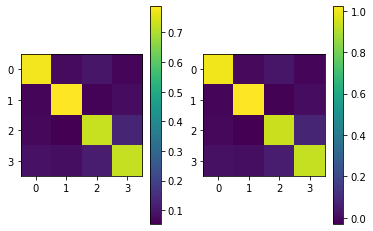

0
1
p_t
0.5070511338952777
rand_vec
[0.25264829 0.24956385 0.24757007 0.25021779]


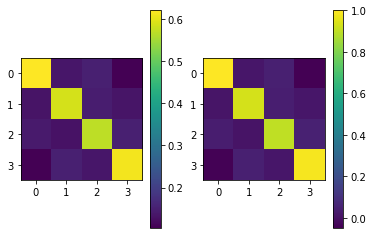

1
2
p_t
0.7042747644421351
rand_vec
[0.25049324 0.24602188 0.24291801 0.26056688]


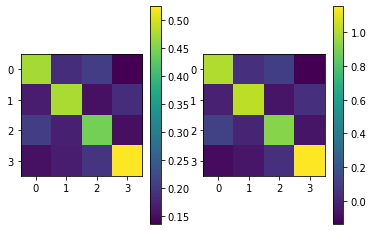

2
3
p_t
0.7877980297204759
rand_vec
[0.26192898 0.24317941 0.24222028 0.25267134]


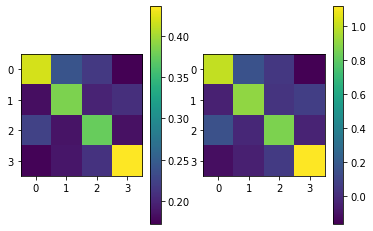

3
4
p_t
0.8733441494465695
rand_vec
[0.26265667 0.24474082 0.23911404 0.25348846]


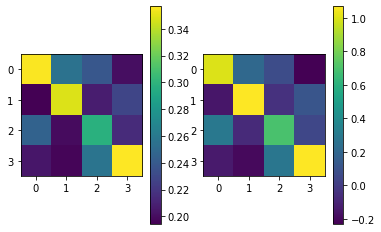

4


In [40]:
circs=[]
fid_raw=[]
fid_GEM=[]
fid_CGP=[]
P_t=[]
b_0=[]
b_1=[]
qst=[]


#preparation of circuits
for i in range (1,N_points+1):
    circs,s_labels,qst=circs_run(i*4,circs,qst)

#execution
print(len(circs))
job=execute(circs,BACKEND,shots=shots,optimization_level=0)
job_result=job.result()
job_counts=job_result.get_counts()

for i in range(0,N_points):
    print(i)
    #define the GEM calibration jobs with meas mitigation
    job_GEM_L=copy.deepcopy(cal_results)
    job_GEM_R=copy.deepcopy(cal_results)
    job_tomo=copy.deepcopy(job_tomo_result)
    job_tomo_aux=copy.deepcopy(job_tomo_result)
    for j in range (0,len(s_labels)):
        job_GEM_L.results[j].data.counts=meas_fitter.filter.apply(job_counts[i*(2*len(s_labels)+3**len(qubits))+j],method="least_squares")
        job_GEM_R.results[j].data.counts=meas_fitter.filter.apply(job_counts[i*(2*len(s_labels)+3**len(qubits))+len(s_labels)+j],method="least_squares")
    for k in range (0,3**(len(qubits))):
        job_tomo.results[k].data.counts=meas_fitter.filter.apply(job_counts[i*(2*len(s_labels)+3**len(qubits))+2*len(s_labels)+k],method="least_squares")
        job_tomo_aux.results[k].data.counts=meas_fitter.filter.apply(job_counts[i*(2*len(s_labels)+3**len(qubits))+2*len(s_labels)+k],method="least_squares")
    

    
    meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L, state_labels=s_labels)
    meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R, state_labels=s_labels)
    Cal_GEM_L = meas_fitter_GEM_L.cal_matrix
    Cal_GEM_R = meas_fitter_GEM_R.cal_matrix
    C=(Cal_GEM_L+Cal_GEM_R)/2
    C_GEM=[]
    C_GEM.append(C)
    C_GEM_plus=[]
    CGP=[]
    
    #define the equilibrium counts distribution
    rand_vec_prob=np.sum(C,axis=1,dtype='float')/(len(s_labels))
    
    
    #calculate the probaabilities of dep error
    p_t=(C[0][0]-1)/(rand_vec_prob[0]-1)
    print('p_t')
    print(p_t)

    #define the random prob vector and equilibrium prob vector
    print('rand_vec')
    print(rand_vec_prob)
    rand_vec=p_t*shots*rand_vec_prob

    D=np.zeros((len(s_labels),len(s_labels)))

    for k in range (0,len(s_labels)):
        for j in range (0,len(s_labels)):
            D[k][j]=(C[k][j]-p_t*rand_vec_prob[k])/(1-p_t)
    CGP.append(D)
    
    
    meas_fitter_GP=copy.deepcopy(meas_fitter)
    meas_fitter_GP.cal_matrices=CGP

    meas_fitter_GEM=copy.deepcopy(meas_fitter)
    meas_fitter_GEM.cal_matrices=C_GEM

    plt.subplot(121)
    plt.imshow(C)
    plt.colorbar()

    plt.subplot(122)
    plt.imshow(D)
    plt.colorbar()
    plt.show()
    tsb=qi.Statevector.from_instruction(final_circ((i+1)*4))
    tomo_fitter = StateTomographyFitter(job_tomo, qst[i])
    rho_fit = tomo_fitter.fit(method='lstsq')
    F_bell_raw= qi.state_fidelity(rho_fit, tsb)
    for k in range (0,3**(len(qubits))):
        raw_vector=itselfmiti1.occurrences_to_vector(job_tomo.results[k].data.counts)
        new_vector_CGP=(raw_vector-rand_vec)/(1-p_t)
        job_tomo_aux.results[k].data.counts=meas_fitter_GP.filter.apply(dict(zip(s_labels,new_vector_CGP)),method="least_squares")
        job_tomo.results[k].data.counts=meas_fitter_GEM.filter.apply(job_tomo.results[k].data.counts,method="least_squares")
    
    tomo_fitter_GEM = StateTomographyFitter(job_tomo, qst[i])
    rho_fit_GEM = tomo_fitter_GEM.fit(method='lstsq')
    F_bell_GEM= qi.state_fidelity(rho_fit_GEM, tsb)
    tomo_fitter_CGP = StateTomographyFitter(job_tomo_aux, qst[i])
    rho_fit_CGP = tomo_fitter_CGP.fit(method='lstsq')
    F_bell_CGP= qi.state_fidelity(rho_fit_CGP, tsb)
    fid_raw.append(F_bell_raw)
    fid_GEM.append(F_bell_GEM)
    fid_CGP.append(F_bell_CGP)
    
    P_t.append(p_t)
    b_0.append(rand_vec_prob[0])
    b_1.append(rand_vec_prob[1])

    print(i)
    


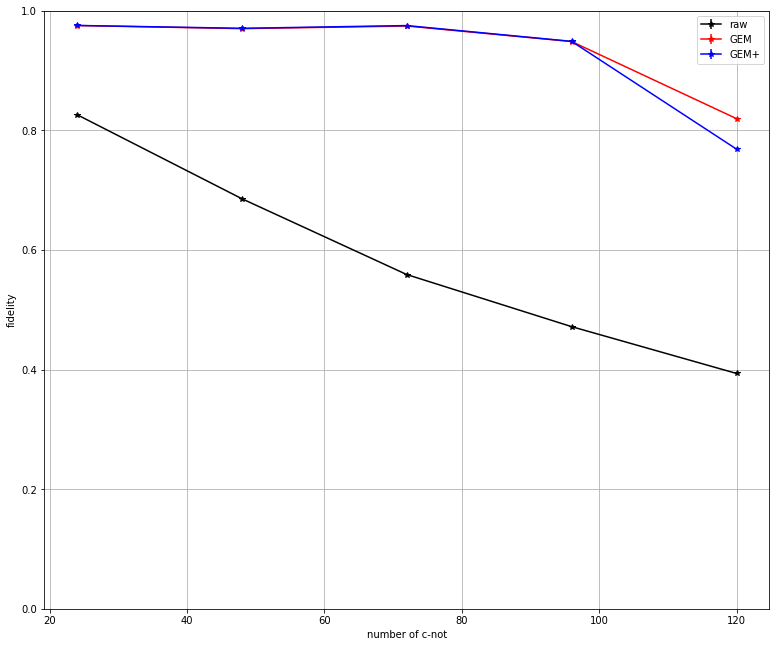

In [41]:

n=np.arange(1,len(fid_GEM)+1,1)
n=n*24
db=0.000000001



plt.figure(figsize=(13,11))
plt.errorbar(n,fid_raw, db, linestyle='-', marker='*', color= 'black',label='raw')
plt.errorbar(n,fid_GEM, db, linestyle='-', marker='*', color= 'red',label='GEM')
plt.errorbar(n,fid_CGP, db, linestyle='-', marker='*', color= 'blue',label='GEM+')




plt.xlabel('number of c-not')
plt.ylabel('fidelity')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

[1 2 3 4 5]
5


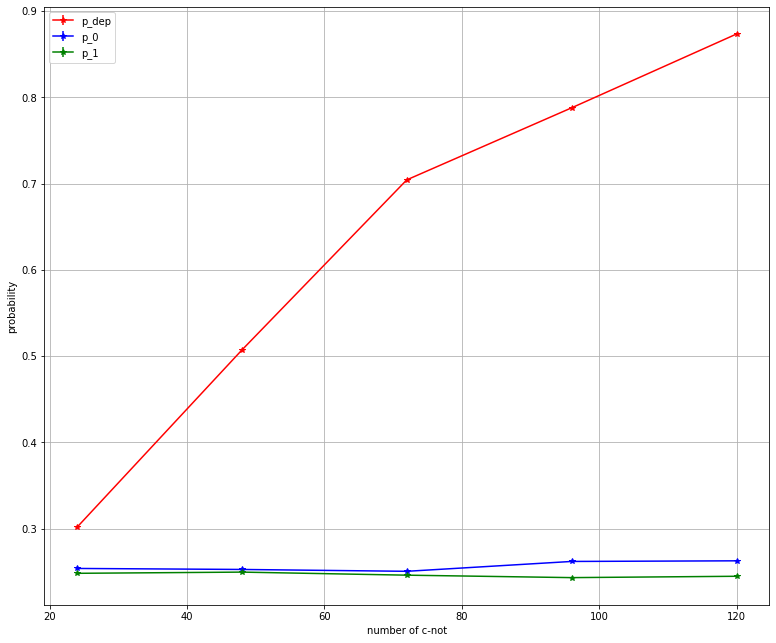

In [42]:

n=np.arange(1,len(fid_GEM)+1,1)
print(n)
print(len(n))
n=n*24
db=0.000000001

plt.figure(figsize=(13,11))
plt.errorbar(n,P_t, db, linestyle='-', marker='*', color= 'red',label='p_dep')
plt.errorbar(n,b_0, db, linestyle='-', marker='*', color= 'blue',label='p_0')
plt.errorbar(n,b_1, db, linestyle='-', marker='*', color= 'green',label='p_1')

plt.xlabel('number of c-not')
plt.ylabel(r'probability')
#plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()